# Which layer of administrative borders to use?

NUTS layers, but also the layers of the currently in-use GADM database have very distinct population and area statistics. So the question that comes up and which I try to answer in here is: which layer, or which combination of layers to choose?

In [1]:
import geopandas as gpd
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

sys.path.append("../")

from src.conversion import area_in_squaremeters

%matplotlib inline

## Remix

As a statistic I will use the average region size per country. The basis will be the NUTS regions. I will then visually inspect the average region size per country and based on the visual inspection decide whether to use the current layer or the a layer with a higher resolution. I will try to keep manipulations at a low level to stay close to the NUTS regions.

In [2]:
adm0 = gpd.read_file("../build/nuts-administrative-borders.gpkg", layer="adm0")
adm1 = gpd.read_file("../build/nuts-administrative-borders.gpkg", layer="adm1")
adm2 = gpd.read_file("../build/nuts-administrative-borders.gpkg", layer="adm2")
adm3 = gpd.read_file("../build/nuts-administrative-borders.gpkg", layer="adm3")
gadm1 = gpd.read_file("../build/administrative-borders.gpkg", layer="adm1")
gadm2 = gpd.read_file("../build/administrative-borders.gpkg", layer="adm2")
gadm3 = gpd.read_file("../build/administrative-borders.gpkg", layer="adm3")

In [3]:
def _average_region_size_per_countrs(regions):
    regions = regions.copy()
    regions["area_km2"] = area_in_squaremeters(regions) / 1000 / 1000
    return regions.groupby("country_code").area_km2.mean()
    

def _plot_layer(regions, map_ax, hist_ax):
    regions.plot(ax=map_ax)
    map_ax.set_xticks([])
    map_ax.set_yticks([])
    avg_region_size = _average_region_size_per_countrs(regions)
    avg_region_size.plot(kind="bar", ax=hist_ax)
    hist_ax.set_xlabel("")
    hist_ax.set_ylabel("average area size [km^2]")
    ymin, ymax = hist_ax.get_ylim()
    hist_ax.text(
        x=12, 
        y=ymax*3/4, 
        s="Std: {:.0f} km^2".format(avg_region_size.std())
    )
    
    
def plot_layers(adm0, adm1, adm2, adm3, path_to_plot=None):
    fig = plt.figure(figsize=(14, 21))
    gs = gridspec.GridSpec(4, 2, height_ratios=[2, 1, 2, 1])
    
    _plot_layer(adm0, fig.add_subplot(gs[0]), fig.add_subplot(gs[2]))
    _plot_layer(adm1, fig.add_subplot(gs[1]), fig.add_subplot(gs[3]))
    _plot_layer(adm2, fig.add_subplot(gs[4]), fig.add_subplot(gs[6]))
    _plot_layer(adm3, fig.add_subplot(gs[5]), fig.add_subplot(gs[7]))
    if path_to_plot:
        fig.savefig(path_to_plot, dpi=300)

In [86]:
import yaml
import pycountry


def read_config(path_to_config):
    with open(path_to_config, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            raise IOError(exc)

            
config = read_config("../config/default.yaml")
codes = [pycountry.countries.lookup(country).alpha_3 for country in config["scope"]["countries"]]   
adm_stats = pd.DataFrame(
    index=codes,
    data= {
    "n_adm1": [adm1[adm1.country_code == country_code].geometry.count() for country_code in codes],
    "n_adm2": [adm2[adm2.country_code == country_code].geometry.count() for country_code in codes],
    "n_adm3": [adm3[adm3.country_code == country_code].geometry.count() for country_code in codes],
    "n_gadm1": [gadm1[gadm1.country_code == country_code].geometry.count() for country_code in codes],
    "n_gadm2": [gadm2[gadm2.country_code == country_code].geometry.count() for country_code in codes],
    "n_gadm3": [gadm3[gadm3.country_code == country_code].geometry.count() for country_code in codes],
    "s_adm1": [_average_region_size_per_countrs(adm1[adm1.country_code == code]).iloc[0] for code in codes],
    "s_adm2": [_average_region_size_per_countrs(adm2[adm2.country_code == code]).iloc[0] for code in codes],
    "s_adm3": [_average_region_size_per_countrs(adm3[adm3.country_code == code]).iloc[0] for code in codes],
    "s_gadm1": [_average_region_size_per_countrs(gadm1[gadm1.country_code == code]).iloc[0] for code in codes],
    "s_gadm2": [_average_region_size_per_countrs(gadm2[gadm2.country_code == code]).iloc[0] for code in codes],
    "s_gadm3": [_average_region_size_per_countrs(gadm3[gadm3.country_code == code]).iloc[0] for code in codes],
    }
)
adm_stats

,n_adm1,n_adm2,n_adm3,n_gadm1,n_gadm2,n_gadm3,s_adm1,s_adm2,s_adm3,s_gadm1,s_gadm2,s_gadm3
AUT,3,9,35,11,98,2127,27982.605474,9327.535158,2398.509041,7623.476184,855.696306,39.425594
BEL,3,11,44,3,12,44,10221.395068,2787.653200,696.913300,10235.821930,2558.955482,697.896950
BGR,2,6,28,28,263,263,55494.380613,18498.126871,3963.884329,3985.273976,424.287724,424.287724
HRV,1,2,21,21,560,560,56599.666132,28299.833066,2695.222197,2718.027465,101.926030,101.926030
CYP,1,1,1,5,5,5,9249.108051,9249.108051,9249.108051,1143.931332,1143.931332,1143.931332
CZE,1,8,14,14,98,98,78869.515454,9858.689432,5633.536818,5626.680105,803.811444,803.811444
DNK,1,5,11,5,99,99,43174.766762,8634.953352,3924.978797,8628.969372,435.806534,435.806534
EST,1,1,5,16,223,4684,45335.411529,45335.411529,9067.082306,2843.116831,203.990445,9.711757
FIN,2,5,19,5,21,80,168808.463856,67523.385542,17769.311985,67388.020110,16044.766693,4211.751257
FRA,8,22,96,22,96,350,68635.275953,24958.282165,5719.606329,24978.009936,5724.127277,1570.046339


### Original Data

Let's first look at the original data and its statistics.

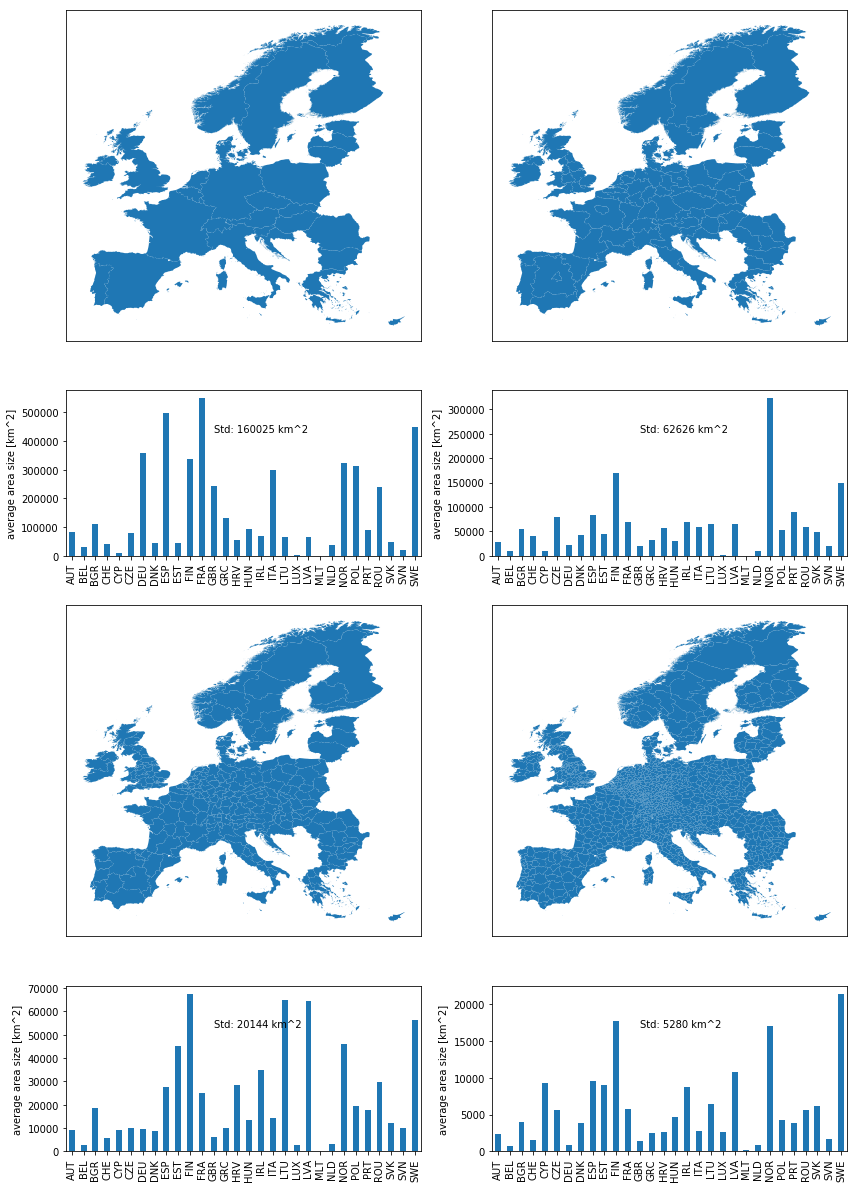

In [5]:
plot_layers(
    adm0=adm0,
    adm1=adm1,
    adm2=adm2,
    adm3=adm3,
    path_to_plot="../build/original-regions.png"
)

One can see that the average region size per country varies quite strongly for all layers. There are two apparent effects:

1) For some countries, moving between layers simply does not impact region size. For example moving from layer 0 to 1, Finland and Norway are not divided into smaller regions.
2) For some countries, moving between layers has only a small effect. For example moving from layer 0 to 1, Sweden is divided into only 3 regions despite the huge size of the country.

For the national layer 0, this variation can hardly be diminshed. For the subnational layers 1-3 it can be improved by choosing lower level layers for some of the countries.

### Remix data

So let's choose some lower layer data to improve the statistics. The heuristic will be to keep changes low to stay close to the NUTS regions.

In [80]:
class Mixer:
    
    def __init__(self, nuts0, nuts1, nuts2, nuts3, gadm1, gadm2, gadm3):
        self.__sources = {
            "nuts0": nuts0,
            "nuts1": nuts1,
            "nuts2": nuts2,
            "nuts3": nuts3,
            "gadm1": gadm1,
            "gadm2": gadm2,
            "gadm3": gadm3
        }        
        self.layers = {
            0: nuts0,
            1: nuts1,
            2: nuts2,
            3: nuts3
        }
        self.__crs = nuts0.crs
        
    def remix_country(self, country_code, data_sources):
        for layer_id in [1, 2, 3]:
            self.layers[layer_id] = self._remix_layer(country_code, layer_id, data_sources[layer_id-1])
        
    def _remix_layer(self, country_code, layer_id, data_source):
        layer = pd.DataFrame(self.layers[layer_id])
        src = self.__sources[data_source]
        layer = layer.drop(
            layer[layer.country_code == country_code].index,
            axis="index"
        )
        df = pd.concat([layer, src[src.country_code == country_code]])
        return gpd.GeoDataFrame(df, crs=self.__crs)    

In [81]:
mixer = Mixer(adm0, adm1, adm2, adm3, gadm1, gadm2, gadm3)
mixer.remix_country("NOR", ["nuts2", "nuts3", "gadm2"])
mixer.remix_country("FIN", ["nuts2", "nuts3", "gadm3"])
mixer.remix_country("SWE", ["nuts2", "nuts3", "gadm2"])
mixer.remix_country("LTU", ["nuts1", "nuts3", "nuts3"])
mixer.remix_country("LVA", ["nuts1", "nuts3", "gadm2"])
mixer.remix_country("EST", ["nuts1", "nuts3", "nuts3"])

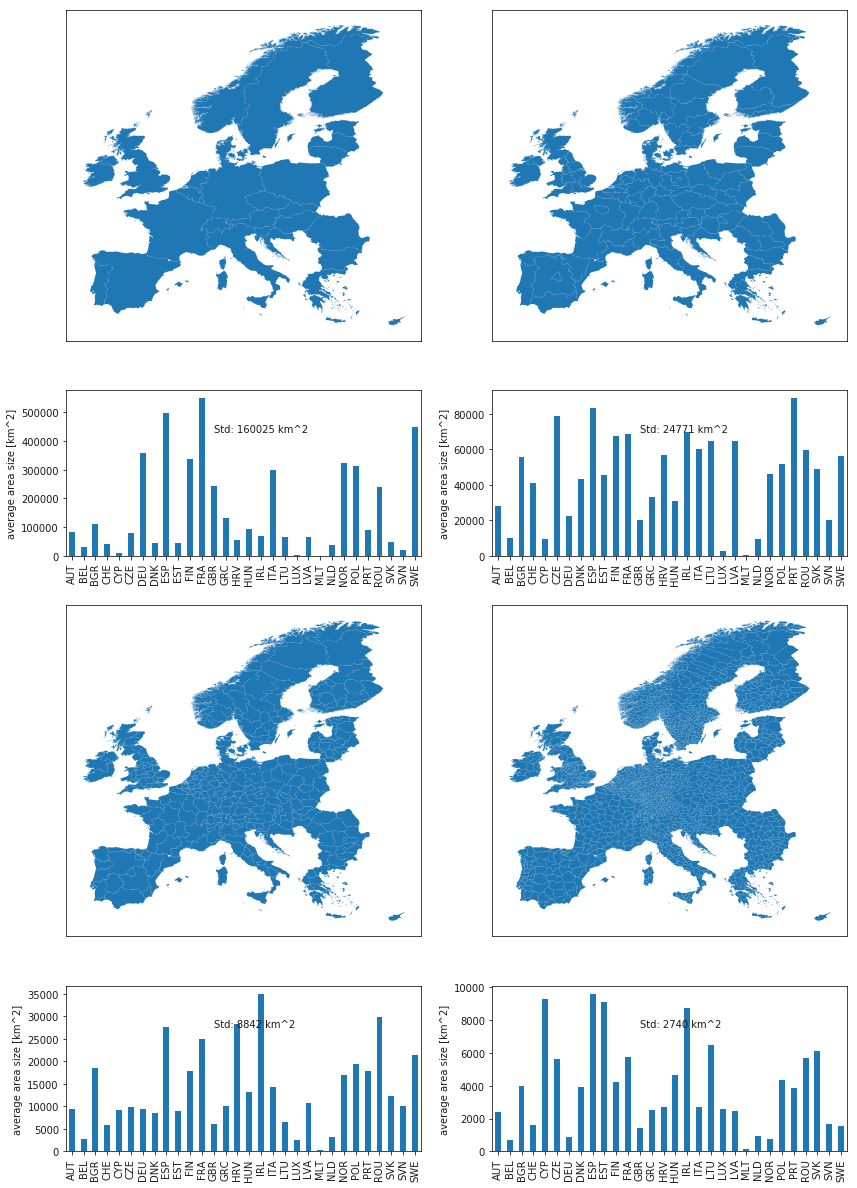

In [82]:
plot_layers(
    adm0=mixer.layers[0],
    adm1=mixer.layers[1],
    adm2=mixer.layers[2],
    adm3=mixer.layers[3],
    path_to_plot="../build/modified-regions.png"
)

### Let's look at the diffs

In [83]:
def plot_diff_histogram(orig_regions, modified_regions, ax, title):
    orig_sizes = _average_region_size_per_countrs(orig_regions).reset_index()
    modified_sizes = _average_region_size_per_countrs(modified_regions).reset_index()
    
    sns.set_color_codes("pastel")
    sns.barplot(
        y="country_code", 
        x="area_km2", 
        data=orig_sizes,
        label="Original (NUTS)", 
        color="b", 
        ax=ax
    )

    sns.set_color_codes("muted")
    sns.barplot(
        y="country_code", 
        x="area_km2", 
        data=modified_sizes,
        label="Modified", 
        color="b", 
        ax=ax
    )
    
    ax.legend(ncol=2, loc="upper right", frameon=True)
    ax.set_title(title)
    

def plot_diff_histograms(orig, modified, path_to_file=None):
    fig = plt.figure(figsize=(14, 14))
    
    plot_diff_histogram(orig["adm0"], modified["adm0"], ax=fig.add_subplot(2,2,1), title="Layer 0")
    plot_diff_histogram(orig["adm1"], modified["adm1"], ax=fig.add_subplot(2,2,2), title="Layer 1")
    plot_diff_histogram(orig["adm2"], modified["adm2"], ax=fig.add_subplot(2,2,3), title="Layer 2")
    plot_diff_histogram(orig["adm3"], modified["adm3"], ax=fig.add_subplot(2,2,4), title="Layer 3")
    
    if path_to_file:
        fig.savefig(path_to_file, dpi=300)
    

def plot_diff_map(orig, modified, ax, title):
    
    orig.plot(color="white", edgecolor='black', linewidth=1, ax=ax)
    modifications = modified[~modified.name.isin(orig.name.values)]
    if modifications.size > 0:
        modifications.plot(edgecolor="black", facecolor="red", linewidth=0.3, ax=ax, alpha=0.4)
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    
    
def plot_diff_maps(orig, modified, path_to_file=None):
    fig = plt.figure(figsize=(14, 14))
    
    plot_diff_map(orig["adm0"], modified["adm0"], ax=fig.add_subplot(2,2,1), title="Layer 0")
    plot_diff_map(orig["adm1"], modified["adm1"], ax=fig.add_subplot(2,2,2), title="Layer 1")
    plot_diff_map(orig["adm2"], modified["adm2"], ax=fig.add_subplot(2,2,3), title="Layer 2")
    plot_diff_map(orig["adm3"], modified["adm3"], ax=fig.add_subplot(2,2,4), title="Layer 3")
    
    if path_to_file:
        fig.savefig(path_to_file, dpi=300)

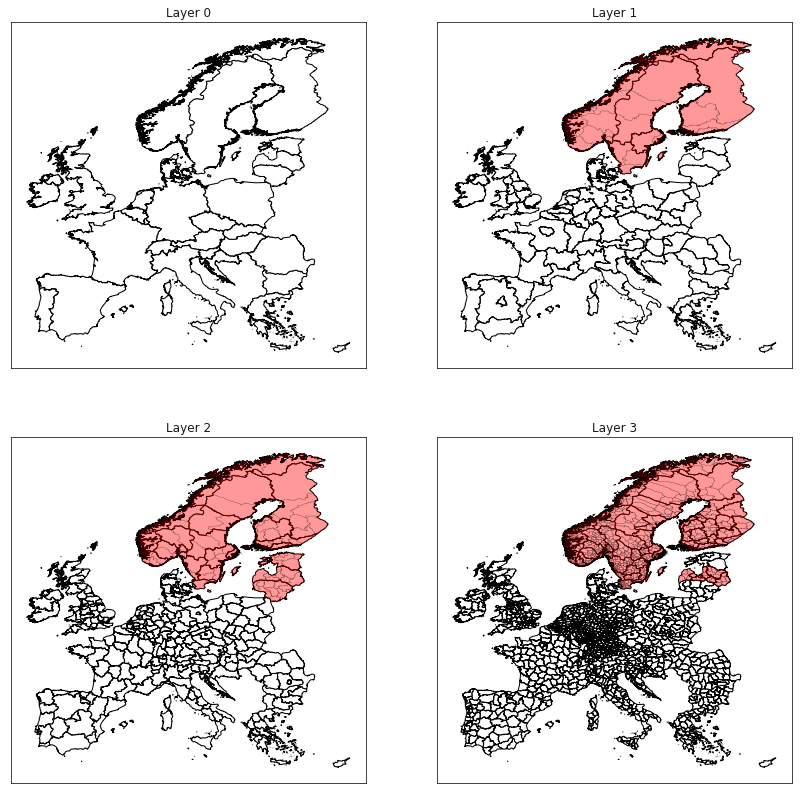

In [84]:
plot_diff_maps(
    orig={"adm0": adm0, "adm1": adm1, "adm2": adm2, "adm3": adm3},
    modified={"adm0": mixer.layers[0], "adm1": mixer.layers[1], "adm2": mixer.layers[2], "adm3": mixer.layers[3]},
    path_to_file="../build/region-diff-map.png"
)

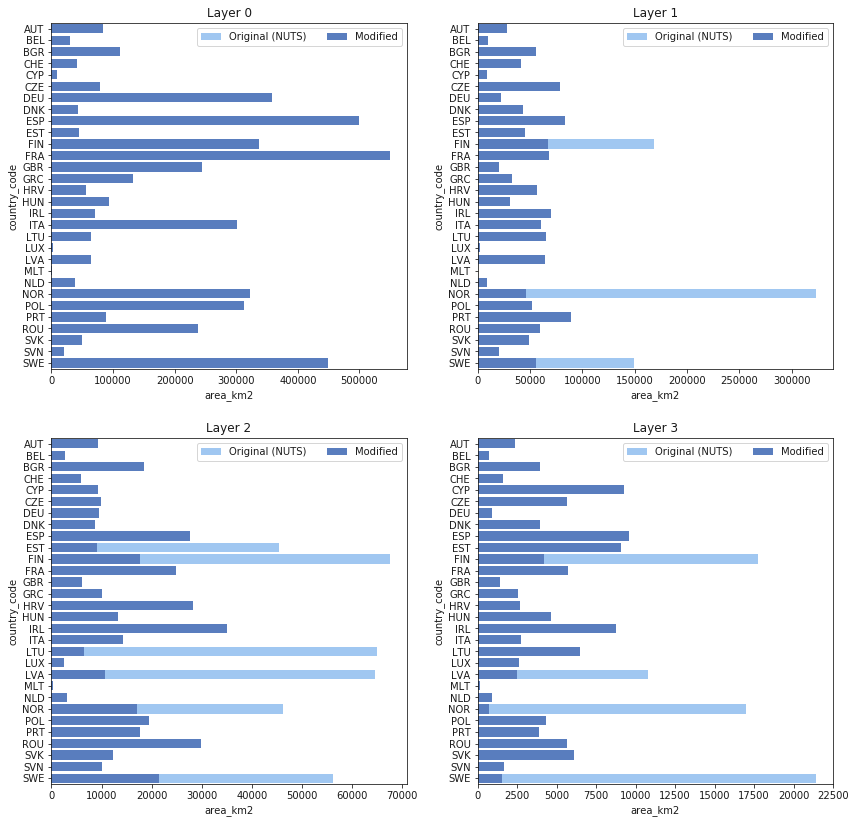

In [85]:
plot_diff_histograms(
    orig={"adm0": adm0, "adm1": adm1, "adm2": adm2, "adm3": adm3},
    modified={"adm0": mixer.layers[0], "adm1": mixer.layers[1], "adm2": mixer.layers[2], "adm3": mixer.layers[3]},
    path_to_file="../build/region-diff-histogramm.pdf"
)